# ADAPT-VQE

ADAPT-VQE was introduced by [Grimsley et al](https://www.nature.com/articles/s41467-019-10988-2) as a solution to the often impracticably deep, and not necessarily accurate, static VQE circuits. In ansatze like UCCSD, one easily reaches the order of thousands of gates, even for modestly sized molecules. In UCCSD and its generalized UCCGSD, the number of fermionic excitations in the ansatz scales like $\mathcal{O}(N^2M^2)$, and $\mathcal{O}(N^4)$ respectively. Here $N$ refers to the number of spin-orbitals in the problem basis, and $M$ the number of electrons.

In ADAPT-VQE, an ansatz which approximates not UCCSD/UCCGSD, but in fact FCI, is built iteratively. Over a series of cycles, the ansatz circuit is grown to achieve an approximation to FCI with a minimal number of circuit elements. In this way, ADAPT-VQE is a meta-VQE. At each step, a new ansatz is defined, and its parameters optimized according to conventional VQE. As the cycles proceed, the ansatz grows in both complexity and expressibility. This algorithm comes at the expense of a significant increase in measurement overhead. In order to identify the best operator to append to the present ansatz circuit, a large number of measurements are performed to rank the available operators in order of their ability to further reduce the ansatz state energy.

In this notebook, we'll explore the implementation of this algorithm, by taking advantage of the tools available through the qSDK. 

## Implementation Strategy

ADAPT-VQE relies on three principal steps.

1. Construct generator pool $\{P_i\}$, a set of available operators from which we will iteratively construct the ansatz.
2. Rank operators by evaluating the gradient for each operator in the pool $\frac{\partial E^{(k)}}{\partial \theta_i} = \langle \psi_k|[H,P_i]|\psi_k\rangle$. Exit if the largest partial derivative is less than some cutoff.
3. Append $U_k = \mathrm{exp}[i\theta_k P_k]$(index) to the ansatz $U=\prod_k U_k(\theta_k)$, and optimize $\langle H\rangle$ using VQE.
4. Return to step 2.

There are two obvious avenues along which one can be creative in the implementation of ADAPT-VQE--these are the selection of the operator pool $\{P_i\}$, and the ranking strategy. Above, we have specified that we are using the gradient to perform this ranking procedure. To my knowledge this is the only method which has been used previously, and we will continue to do so here. Regarding the choice of operator pool, the original authors used the elements of the UCCGSD, i.e. the single, double fermionic excitations. Subsequent work has focused on qubit-native operators, and we'll follow this strategy as well. Although the UCCGSD allows for high accuracy with a small number of cycles (and consequently very few variational parameters), the circuit remains very deep, as each excitation consists of many multi-qubit Pauli rotations. 

## Hamiltonian-Inspired Qubit-ADAPT
We are going to use the Hamiltonian to establish a set of pool generators to use in our implementation of ADAPT-VQE. For each term in the Hamiltonian which acts on a distinct combination of qubits, we'll add a pool operator which is guaranteed to have a non-zero commutator with respect to H, and therefore a finite gradient. This will give us a fairly compact set of operators in the pool, all of which are likely to be useful in our ansatz construction. To do this, we will scan through all terms in the qubit Hamiltonian. For each, we will identify the Pauli operators associated with electronic excitation (X and Y gates). We discard Z gates from the Pauli string. If the number of Y gates in a string is even, we can use this to construct an excitation pool element that preserves T-symmetry, by flipping one of the other X gates to a Y, or a Y to an X. Below, we'll flip the first X or Y to its partner.

In [2]:
def get_pool(qubit_hamiltonian, n_qubits):
    """Use Hamiltonian to identify non-commuting Pauli strings to use as operator pool.
    We identify terms with even number of Y-operators, in order to define excitations 
    which preserve T-reversal symmetry. We remove all Z operators, and we flip the first
    X or Y to its partner (i.e. X <> Y).
    Args:
        qubit_hamiltonian (QubitOperator): input Hamiltonian
        n_qubits (int): number of qubits for Hamiltonian
    
    Returns:
        pool_generators (list of QubitOperator): list of generators
    """
    import numpy as np
    from qsdk.toolboxes.operators.operators import QubitOperator

    pauli_lookup = {'Z':1, 'X':2, 'Y':3}
    pauli_reverse_lookup = ['I', 'Z', 'X', 'Y']
    pool_generators, pool_tuples = list(), list()
    indices = list()

    for term in qubit_hamiltonian.terms:
        pauli_string = np.zeros(n_qubits, dtype=int)
        
        #identify all X or Y factors
        for index, action in term:
            if pauli_lookup[action] > 1:
                pauli_string[index] = pauli_lookup[action]

        #only allow one operator acting on a given set of qubits
        action_mask = tuple(pauli_string > 1)
        if action_mask in indices:
            continue

        #only consider terms with even number of Y
        if sum(pauli_string) % 2 == 0 and sum(pauli_string) > 0:
            #identify qubit operator to change X<>Y
            flip_index = np.where(pauli_string > 1)[0][0]
            pauli_string[flip_index] += (-1)**(pauli_string[flip_index] % 2) 

            #update set of used qubit combinations
            indices.append(action_mask)
            #create QubitOperator for the new generator
            operator_tuple = tuple([(index,pauli_reverse_lookup[pauli]) for index, pauli in enumerate(pauli_string) if pauli > 0])
            #We don't use the coefficients directly, so since we need to multiply by 1.j for evaluating gradients, 
            #I'm just instantiating these with that coefficient in place
            pool_generators.append(QubitOperator(operator_tuple, 1.0j))
            pool_tuples.append(operator_tuple)
    
    return pool_generators

To exemplify the generation of an operator pool, we will apply this method to a simple Hamiltonian consisting of a single fermionic excitation and its Hermitian conjugate.

In [3]:
from qsdk.toolboxes.operators import QubitOperator
qubit_hamiltonian = QubitOperator(((0, 'X'), (1, 'X'), (2, 'Y'), (3, 'Y')), -1.0) \
                  + QubitOperator(((0, 'X'), (1, 'Y'), (2, 'Y'), (3, 'X')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'X'), (2, 'X'), (3, 'Y')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'Y'), (2, 'X'), (3, 'X')), -1.0) 
pool_generators = get_pool(qubit_hamiltonian, n_qubits=4)
print(f'OPERATOR POOL: {pool_generators}')

OPERATOR POOL: [1j [Y0 X1 Y2 Y3]]


We have used a qubit Hamiltonian where all operators act on the same qubit indices. This results in just a single generator pool element. As we traverse the `qubit_hamiltonian` in order, the generator corresponds to the first term in the Hamiltonian, with the first X operator switched to a Y operator. So from XXYY, we have YXYY. 

## Defining the problem
For the generator pool we've considered here, the smallest non-trivial problem to consider is H$_4$, as H$_2$ has only one generator and ADAPT terminates at FCI accuracy after a single iteration. So we'll apply this here to H$_4$ as a linear chain. We begin by instantiating the molecule object from pyscf's `gto.Mole` class, and feed this into the `do_adapt_vqe` method we defined above.

In [121]:
from pyscf import gto

H4 = [('H', (0, 0, 0)), ('H', (0, 0, 1.41)), ('H', (0, 0, 2.82)), ('H', (0, 0, 4.23))]
mol = gto.Mole()
mol.atom = H4
mol.basis = 'sto-3g'
mol.build()

uccsd_solver = VQESolver({'molecule': mol})
uccsd_solver.build()

qubit_hamiltonian = uccsd_solver.qubit_hamiltonian
n_qubits = uccsd_solver.ansatz.circuit.width

## Assembling the ADAPT Workflow
With the problem defined and the get_pool function prepared, we can proceed to initiate the ADAPT-VQE method. This is as simple as defining the problem with a dictionary and initiating the `ADAPTSolver` class.

In [131]:
from qsdk.electronic_structure_solvers import ADAPTSolver

opt_dict = {"molecule": mol,
            "frozen_orbitals": 0,
            "pool": get_pool,
            "pool_args": (qubit_hamiltonian, n_qubits),
            "tol": 0.01,
            "max_cycles": 12,
            "verbose": False}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()

In [123]:
adapt_solver.simulate()

Iteration 1 of ADAPT-VQE.
Iteration 2 of ADAPT-VQE.
Iteration 3 of ADAPT-VQE.
Iteration 4 of ADAPT-VQE.
Iteration 5 of ADAPT-VQE.
Iteration 6 of ADAPT-VQE.
Iteration 7 of ADAPT-VQE.
Iteration 8 of ADAPT-VQE.
Iteration 9 of ADAPT-VQE.
Iteration 10 of ADAPT-VQE.
Iteration 11 of ADAPT-VQE.
Iteration 12 of ADAPT-VQE.


-2.024136449751694

After 15 cycles, we force the cycle to terminate. At this point, the largest gradient is below the level of 0.01. We can now compare the results against the predictions of FCI.

Final Error: 1.4719E-03


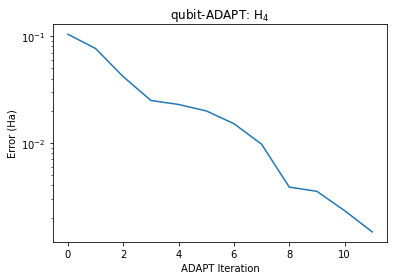

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from qsdk.toolboxes.molecular_computation.molecular_data import MolecularData
from qsdk.electronic_structure_solvers.fci_solver import FCISolver
solver = FCISolver()
exact = solver.simulate(mol)
errors = np.array(adapt_solver.energies) - exact
fig,ax = plt.subplots(1,1)
ax.plot(errors)
ax.set_xlabel('ADAPT Iteration')
ax.set_ylabel('Error (Ha)')
ax.set_title('qubit-ADAPT: H$_4$')
ax.set_yscale('log')
print(f'Final Error: {errors[-1] :.4E}')

Ok so after 15 cycles, we have an error of 0.14 mHa, within chemical accuracy of FCI. How does this all compare against UCCSD-VQE?

In [125]:
uccsd_solver.simulate()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0246341192737987
            Iterations: 6
            Function evaluations: 97
            Gradient evaluations: 6


-2.0246341192737987

In [126]:
print(f'ADAPT-VQE ERROR: {adapt_solver.energies[-1] - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {uccsd_solver.optimal_energy - exact :0.4E} Ha')

ADAPT-VQE ERROR: 1.4719E-03 Ha
UCCSD-VQE ERROR: 9.7418E-04 Ha


From the perspective of energy accuracy, the two have reached very similar results, within a factor of two. The big advantage here however, are in the resources required for this ansatz circuit:

In [127]:
print(f'ADAPT RESOURCES:\n {adapt_solver.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {uccsd_solver.get_resources()}')

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 184, 'circuit_2qubit_gates': 72, 'circuit_var_gates': 12, 'vqe_variational_parameters': 12}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}



We have managed here to reduce the total number of gates by a factor of 10, the number of 2-qubit gates by a factor of nearly 15, and variational gates by a factor of 10. 

We note that ADAPT-VQE has run with 2 more variational parameters than UCCSD-VQE. This introduces additional overhead to the classical optimizer, which must find an optimal solution within a higher-dimensional space. However, the number of variational parameters for ADAPT-VQE is directly dependent on the number of cycles over which ADAPT is run. We then have the opportunity to compromise between optimization complexity and ansatz expressivity by limiting the number of cycles, and therefore the number of variational parameters (and gate number and depth) associated with a computation. This flexibility in resource requirements is then an important advantage for the ADAPT-VQE algorithm over static ansatze.

There is one small problem with qubit inspired ansatz. They do not generally respect the symmetry of the problem. We can now examing the operators $\hat{S}^2$, $\hat{S}_Z$ and the $\hat{N}$ operators to determine if any loss of symmetry has occured. 

In [128]:
from qsdk.toolboxes.ansatz_generator.fermionic_operators import number_operator, spinz_operator, spin2_operator
from qsdk.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
n_orbs = int(mol.nao)
s2hat = spin2_operator(n_orbs)
szhat = spinz_operator(n_orbs)
nhat = number_operator(n_orbs)
qu_s2hat = fermion_to_qubit_mapping(s2hat, 'jw')
qu_szhat = fermion_to_qubit_mapping(szhat, 'jw')
qu_nhat = fermion_to_qubit_mapping(nhat, 'jw')
adapt_s2 = adapt_solver.vqe_solver.operator_expectation(qu_s2hat)
adapt_sz = adapt_solver.vqe_solver.operator_expectation(qu_szhat)
adapt_n = adapt_solver.vqe_solver.operator_expectation(qu_nhat)
uccsd_s2 = uccsd_solver.operator_expectation(qu_s2hat)
uccsd_sz = uccsd_solver.operator_expectation(qu_szhat)
uccsd_n = uccsd_solver.operator_expectation(qu_nhat)

print(f'Adapt quantum numbers: N = {adapt_n:6.4f}, Sz = {adapt_sz:6.4f}, S^2 = {adapt_s2:6.4f}')
print(f'UCCSD quantum numbers: N = {uccsd_n:6.4f}, Sz = {uccsd_sz:6.4f}, S^2 = {uccsd_s2:6.4f}')

Adapt quantum numbers: N = 4.0001, Sz = 0.0004, S^2 = 0.0015
UCCSD quantum numbers: N = 4.0000, Sz = 0.0000, S^2 = 0.0000


As you can see, there are small errors in the desired quantum numbers so the resulting state is not exactly what we wanted. To address this problem we can add a penalty term to the qubit hamiltonian and minimize this qubit_hamiltonian directly using Adapt-VQE instead of the molecular hamiltonian.

In [129]:
from qsdk.toolboxes.ansatz_generator.penalty_terms import combined_penalty
qubit_hamiltonian = uccsd_solver.qubit_hamiltonian
qubit_hamiltonian_with_pen = qubit_hamiltonian + fermion_to_qubit_mapping(combined_penalty(n_orbs, opt_penalty_terms={'N': [1/2, 4], 'Sz': [1, 0], 'S^2': [1, 0]}), 'jw')
opt_dict = {"qubit_hamiltonian": qubit_hamiltonian_with_pen,
            "n_electrons": 4,
            "n_spinorbitals": 2 * n_orbs, 
            "pool": get_pool,
            "pool_args": (qubit_hamiltonian_with_pen, n_qubits),
            "tol": 0.01,
            "max_cycles": 12,
            "verbose": False}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()
adapt_solver.simulate()

Iteration 1 of ADAPT-VQE.
Iteration 2 of ADAPT-VQE.
Iteration 3 of ADAPT-VQE.
Iteration 4 of ADAPT-VQE.
Iteration 5 of ADAPT-VQE.
Iteration 6 of ADAPT-VQE.
Iteration 7 of ADAPT-VQE.
Iteration 8 of ADAPT-VQE.
Iteration 9 of ADAPT-VQE.
Iteration 10 of ADAPT-VQE.
Iteration 11 of ADAPT-VQE.
Iteration 12 of ADAPT-VQE.


-2.019190327311798

In [130]:
adapt_s2 = adapt_solver.vqe_solver.operator_expectation(qu_s2hat)
adapt_sz = adapt_solver.vqe_solver.operator_expectation(qu_szhat)
adapt_n = adapt_solver.vqe_solver.operator_expectation(qu_nhat)

print(f'ADAPT-VQE ERROR: {adapt_solver.vqe_solver.operator_expectation(qubit_hamiltonian) - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {uccsd_solver.optimal_energy - exact :0.4E} Ha\n')
print(f'ADAPT RESOURCES:\n {adapt_solver.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {uccsd_solver.get_resources()}\n')
print(f'Adapt quantum numbers:\n N = {adapt_n:6.4f}, Sz = {adapt_sz:6.4f}, S^2 = {adapt_s2:6.4f}\n')
print(f'UCCSD quantum numbers:\n N = {uccsd_n:6.4f}, Sz = {uccsd_sz:6.4f}, S^2 = {uccsd_s2:6.4f}')

ADAPT-VQE ERROR: 6.4019E-03 Ha
UCCSD-VQE ERROR: 9.7418E-04 Ha

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 695, 'circuit_width': 8, 'circuit_gates': 184, 'circuit_2qubit_gates': 72, 'circuit_var_gates': 12, 'vqe_variational_parameters': 12}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}

Adapt quantum numbers:
 N = 4.0000, Sz = -0.0000, S^2 = 0.0000

UCCSD quantum numbers:
 N = 4.0000, Sz = 0.0000, S^2 = 0.0000


## Conclusion

In this notebook, we've explored a simple implementation of the ADAPT-VQE algorithm, using tools available through the qSDK. We have demonstrated how we can leverage these tools to reduce the effort involved in prototyping new quantum algorithms. This allows the user to focus exclusively on the specific components relevant to their research objectives, without getting bogged down in re-building standard infrastructure from scratch. 

The ADAPT-VQE algorithm provides the flexibility to explore different choices of generator pools, and ranking criteria. Feel free to try out alternative implementations to get a better sense of what this algorithm can do.